In [ ]:
%%capture
%%bash
pip install pymc3==3.8
pip install arviz==0.6.1
pip install Theano==1.0.4

mkdir data/
wget -P ./data/ https://github.com/sachinruk/bayes_school/raw/master/data/all_stocks_5yr.csv.zip 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.linear_model import LinearRegression

import pymc3 as pm
from pymc3 import plot_posterior

%matplotlib inline

The data was downloaded from https://www.kaggle.com/camnugent/sandp500

In [ ]:
df = pd.read_csv('./data/all_stocks_5yr.csv.zip', compression='zip')
df["Date"] = pd.to_datetime(df["Date"])
df["t_section"] = df["Date"].dt.year - df["Date"].dt.year.min()
df.head()

Date   Open   High    Low  Close     Volume Name  t_section
0 2012-08-13  92.29  92.59  91.74  92.40  2075391.0  MMM          0
1 2012-08-14  92.36  92.50  92.01  92.30  1843476.0  MMM          0
2 2012-08-15  92.00  92.74  91.94  92.54  1983395.0  MMM          0
3 2012-08-16  92.75  93.87  92.21  93.74  3395145.0  MMM          0
4 2012-08-17  93.93  94.30  93.59  94.24  3069513.0  MMM          0

In [ ]:
stocks = ['MSFT']
df_stocks = df.loc[df.Name.isin(stocks), ['Date', 'Close', 'Name', 't_section']]
print(df_stocks.shape)
df_stocks.head()

(1258, 4)


Date  Close  Name  t_section
380416 2012-08-13  30.39  MSFT          0
380417 2012-08-14  30.13  MSFT          0
380418 2012-08-15  30.20  MSFT          0
380419 2012-08-16  30.78  MSFT          0
380420 2012-08-17  30.90  MSFT          0

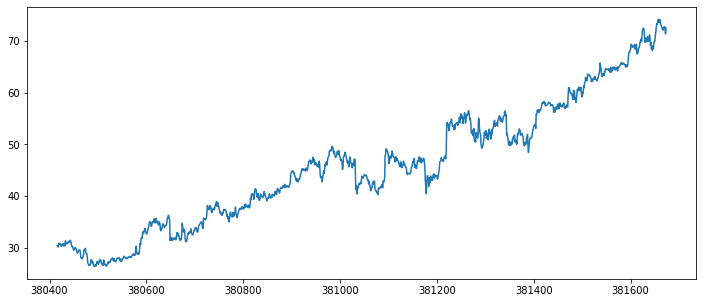

In [ ]:
df_stocks["Close"].plot(figsize=(12, 5))
plt.show()

## Generating Synthetic data
$$
\begin{align}
y_t &= y_{t-1} + \xi_t\\
\xi_t &\sim \mathcal{N}(0, 1)
\end{align}
$$

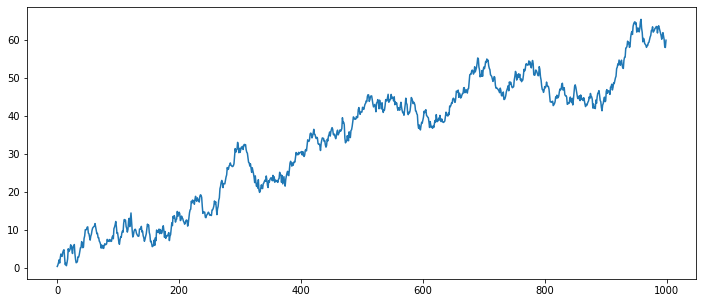

In [ ]:
N = 1000
D = 1

e = np.random.randn(N, D)

y2 = np.cumsum(e, axis=0)
plt.figure(figsize=(12, 5))
plt.plot(y2)
plt.show()

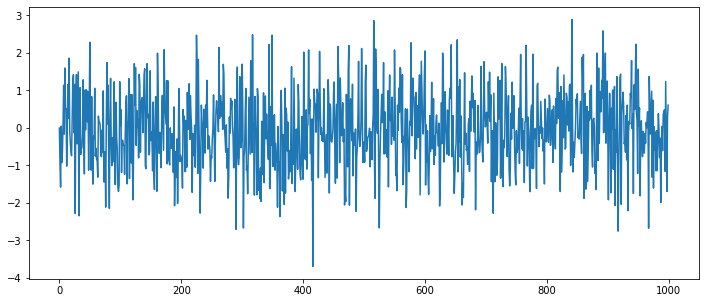

In [ ]:
N = 1000
D = 1

e = np.random.randn(N, D)

plt.figure(figsize=(12, 5))
plt.plot(e)
plt.show()

## Inference Process

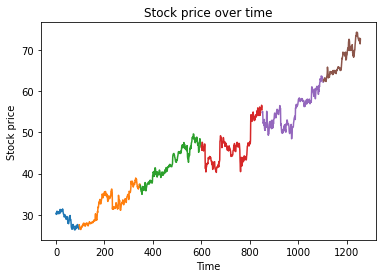

In [ ]:
N = len(df_stocks)
t_section = df_stocks["t_section"].values

t = np.arange(len(df_stocks))

for i in range(t_section.max()+1):
    time = t[t_section==i]
    stock_val = df_stocks.loc[t_section==i,'Close'].values
    plt.plot(time, stock_val)
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.title('Stock price over time')
plt.show()

## Scikit-Learn Method

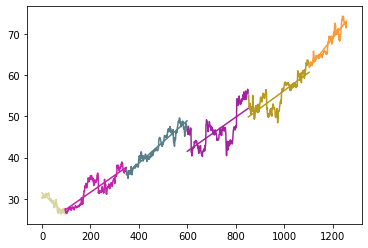

In [ ]:
k = t_section.max()+1
color = np.random.rand(k, 3)
for i in range(k):
    time = t[t_section==i][:,None]
    stock_val = df_stocks.loc[t_section==i,'Close'].values[:,None]
    model = LinearRegression()
    model.fit(time, stock_val)
    y_pred = model.predict(time)
    
    plt.plot(time, stock_val, c=color[i])
    plt.plot(time, y_pred, c=color[i])
    
plt.show()

In [ ]:
y_mean = df_stocks["Close"].mean()
y_std = df_stocks["Close"].std()
y = (df_stocks["Close"].values - y_mean) / y_std

t = df_stocks["Date"].values.astype(float)
t_mean = t.mean()
t_std = t.std()
t = (t-t_mean) / t_std

Gaussian process on regression
\begin{align}
\alpha_T &= \alpha_{T-1} + \xi_\alpha \\
\beta_T &= \beta_{T-1} + \xi_\beta \\
\xi_\alpha &\sim \mathcal{N}(0, \sigma_\alpha) \\
\xi_\beta &\sim \mathcal{N}(0, \sigma_\beta) \\
\end{align}
The trend line is donated as being:
$$
\mu = \alpha_T + \beta_T t
$$
While the observations are taken to be:
$$
y_t = \mu + \xi_y\\
\xi_y \sim \mathcal{N}(0, \sigma_y)
$$

In [39]:
t_section

array([0, 0, 0, ..., 5, 5, 5], dtype=int64)

In [ ]:
def rolling_regression_model(t_t, y_t, k, n_samples=500):
    with pm.Model() as model:
        sd_α = pm.Uniform('sd_α', lower=0, upper=1)
        sd_β = pm.Uniform('sd_β', lower=0, upper=1)

        α = pm.GaussianRandomWalk('alpha', sigma=sd_α, shape=k)
        β = pm.GaussianRandomWalk('beta', sigma=sd_β, shape=k)
        
        # usual regression
        alpha_r = α[t_section_t]
        beta_r = β[t_section_t]
        regression = alpha_r+beta_r*t_t

        sd = pm.Uniform('sd', 0, 1)
        likelihood = pm.Normal('y', mu=regression, sd=sd, observed=y_t)
        trace = pm.sample(n_samples)

    return trace

t_t = t.squeeze()
y_t = y.squeeze()
t_section_t = t_section.squeeze()
trace = rolling_regression_model(t_t, y_t, k, n_samples=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, beta, alpha, sd_β, sd_α]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:32<00:00, 31.22it/s]
The acceptance probability does not match the target. It is 0.8891866378068602, but should be close to 0.8. Try to increase the number of tuning steps.


In [ ]:
trace['alpha'].shape, trace['sd'].shape

((1000, 6), (1000,))

In [ ]:
a_mean = trace['alpha'].mean(axis=0)
b_mean = trace['beta'].mean(axis=0)

y_pred = a_mean[t_section] + b_mean[t_section]*t

# Un-normalise the data
y_pred = y_pred*y_std + y_mean

y = df_stocks["Close"].values
dates = df_stocks["Date"].values

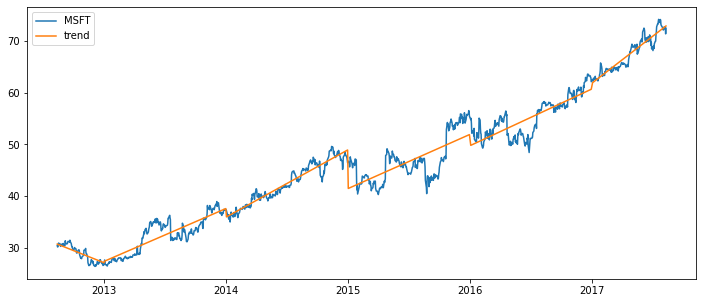

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(dates, y, label="MSFT")
plt.plot(dates, y_pred, label="trend")
plt.legend()
plt.show()

In [ ]:
y_pred = trace['alpha'].T[t_section] + trace['beta'].T[t_section]*t[:,None]
y_pred = y_pred.T
y_pred.shape

(1000, 1258)

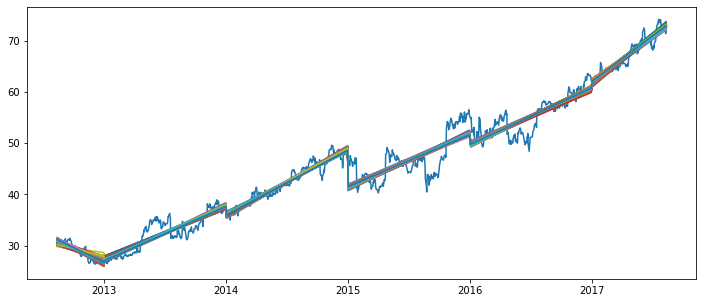

In [ ]:
idx = np.random.choice(len(y_pred), 200)

plt.figure(figsize=(12,5))
plt.plot(dates, y)
for i in idx:
    trend = y_pred[i]*y_std + y_mean
    plt.plot(dates, trend)

plt.show()

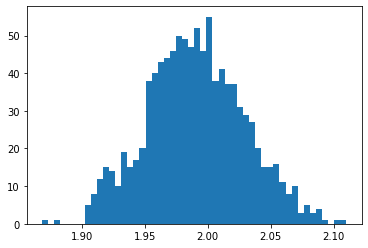

In [ ]:
plt.hist(trace['sd']*y_std, 50)
plt.show()

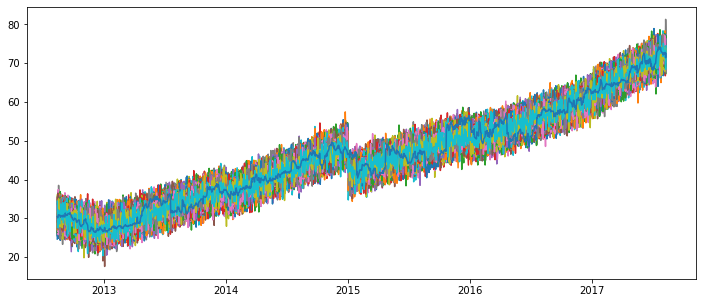

In [ ]:
plt.figure(figsize=(12,5))
for i in idx:
    y_obs = y_pred[i] + trace['sd'][i] * np.random.randn((len(y)))
    plt.plot(dates, y_obs*y_std + y_mean)
plt.plot(dates, y)
plt.show()

## Forecasting

In [ ]:
y_mean = df_stocks["Close"].mean()
y_std = df_stocks["Close"].std()
y = (df_stocks["Close"].values - y_mean) / y_std

t = df_stocks["Date"].values.astype(float)
t_mean = t.mean()
t_std = t.std()
t = (t-t_mean) / t_std

In [ ]:
t_t = t.squeeze()
y_t = y.squeeze()
t_section_t = t_section.squeeze()
trace = rolling_regression_model(t_t, y_t, k+1, n_samples=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, beta, alpha, sd_β, sd_α]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:28<00:00, 35.49it/s]


In [ ]:
t_ahead = pd.date_range(start=df_stocks["Date"].max(), freq="1d", periods=365)
t_new = df_stocks["Date"].append(pd.Series(t_ahead))
t_section_new = (t_new.dt.year - t_new.dt.year.min()).values
t_new_normalised = (t_new.values.astype(float) - t_mean) / t_std

In [ ]:
t_section, t_section_new

(array([0, 0, 0, ..., 5, 5, 5], dtype=int64), array([0, 0, 0, ..., 6, 6, 6]))

In [ ]:
y_pred = trace['alpha'].T[t_section_new] + trace['beta'].T[t_section_new]*t_new_normalised[:,None]
y_pred = y_pred.T
y_pred.shape

(1000, 1623)

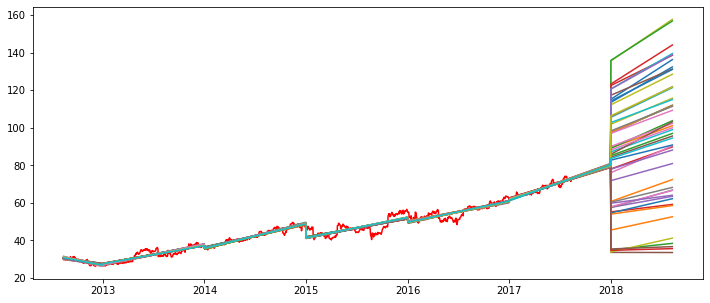

In [ ]:
y_pred_unnormalised = y_pred * y_std + y_mean
idx = np.random.choice(len(y_pred), 50)

plt.figure(figsize=(12, 5))
plt.plot(df_stocks["Date"], df_stocks["Close"], c="r")
for i in idx:
    plt.plot(t_new.values, y_pred_unnormalised[i])
plt.show()